In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import pickle

## Data cleaning
Leggo il dataset, levo le colonne che non sono inerenti per l'addestramento del modello e lo divido il dataset in modo da avere dati da dare in pasto al modello una volta in funzione

In [ ]:
file_path = "Dataset.csv"
df = pd.read_csv(file_path,encoding='utf-8')
df = df.drop(df.index[11330:19342])
x = df['Query']  # Query SQL
y = df['Label']  # Lab
print(df.count())
x_train,x_use,y_train,y_use= train_test_split(x,y,test_size=0.2,random_state=42)
df= pd.DataFrame(x_train)
df['Label'] = y_train

Ora che ho il mio sub-dataset, posso procedere con la fase di data cleaning, in primis procedo ad portare tutto in minuscolo

In [4]:
df['Query'] = df['Query'].str.lower()
df

,Query,Label
26851,select fairly ( s from volume right join,0
1866,1' in boolean mode ) order by 1--,1
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1
26246,select * from tone where several between '1996...,0
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1
...,...,...
19976,"select left ( customername, 5 ) as extractst...",0
29587,select * from her where yes between deep09/01/...,0
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1
860,"select * from users where id = 1 or 1#""{ un...",1


Elimino gli spazi bianchi iniziali e finali

In [5]:
df['Query'] = df['Query'].str.strip()
df

,Query,Label
26851,select fairly ( s from volume right join,0
1866,1' in boolean mode ) order by 1--,1
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1
26246,select * from tone where several between '1996...,0
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1
...,...,...
19976,"select left ( customername, 5 ) as extractstr...",0
29587,select * from her where yes between deep09/01/...,0
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1
860,"select * from users where id = 1 or 1#""{ uni...",1


Rimuovo il select iniziale da ogni query

In [6]:
def remove_select_at_start(query):
    if query.startswith('select'):
        return query[len('select'):].lstrip()
    else:
        return query

df['Query'] = df['Query'].apply(remove_select_at_start)
df

,Query,Label
26851,fairly ( s from volume right join,0
1866,1' in boolean mode ) order by 1--,1
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1
26246,* from tone where several between '1996-07-01'...,0
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1
...,...,...
19976,"left ( customername, 5 ) as extractstring fro...",0
29587,* from her where yes between deep09/01/1996sle...,0
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1
860,"* from users where id = 1 or 1#""{ union sele...",1


Creo la feature lunghezza, dato che la maggior parte delle query con una lunghezza più grande e molto probabile che sia malevola

In [7]:
df['lunghezza'] = df['Query'].apply(len)
df

,Query,Label,lunghezza
26851,fairly ( s from volume right join,0,33
1866,1' in boolean mode ) order by 1--,1,36
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1,65
26246,* from tone where several between '1996-07-01'...,0,63
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1,166
...,...,...,...
19976,"left ( customername, 5 ) as extractstring fro...",0,58
29587,* from her where yes between deep09/01/1996sle...,0,76
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1,51
860,"* from users where id = 1 or 1#""{ union sele...",1,75


Creo una nuova feature che mi dica quante select ci sono in una query

In [8]:
df['Select_Count'] = df['Query'].str.count('select')
df

,Query,Label,lunghezza,Select_Count
26851,fairly ( s from volume right join,0,33,0
1866,1' in boolean mode ) order by 1--,1,36,0
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1,65,0
26246,* from tone where several between '1996-07-01'...,0,63,0
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1,166,0
...,...,...,...,...
19976,"left ( customername, 5 ) as extractstring fro...",0,58,0
29587,* from her where yes between deep09/01/1996sle...,0,76,0
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1,51,0
860,"* from users where id = 1 or 1#""{ union sele...",1,75,1


Controllo se è bilanciato

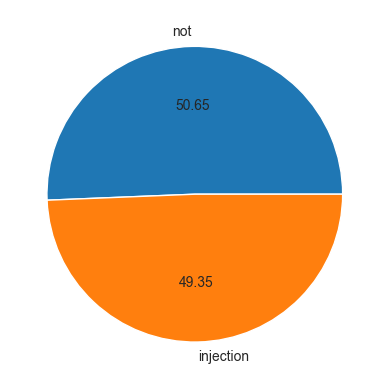

Label
0    9281
1    9044
Name: count, dtype: int64

In [9]:
plt.pie(y_train.value_counts(), labels=['not', 'injection'], autopct="%0.2f")
plt.show()
y_train.value_counts()

# Data visualization

Visualizzo la distribuzione di query in base alla lunghezza 

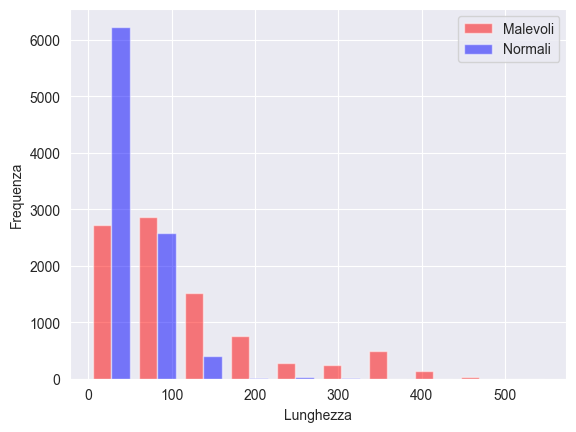

,Query,Label,lunghezza,Select_Count
26851,fairly ( s from volume right join,0,33,0
1866,1' in boolean mode ) order by 1--,1,36,0
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1,65,0
26246,* from tone where several between '1996-07-01'...,0,63,0
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1,166,0
...,...,...,...,...
19976,"left ( customername, 5 ) as extractstring fro...",0,58,0
29587,* from her where yes between deep09/01/1996sle...,0,76,0
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1,51,0
860,"* from users where id = 1 or 1#""{ union sele...",1,75,1


In [11]:

# Crea due sottoinsiemi del DataFrame in base al valore di 'target'
df_target_1 = df[df['Label'] == 1]
df_target_0 = df[df['Label'] == 0]

# Crea l'istogramma
plt.hist([df_target_1['lunghezza'], df_target_0['lunghezza']], color=['r','b'], alpha=0.5)


plt.xlabel('Lunghezza')
plt.ylabel('Frequenza')
plt.legend(['Malevoli', 'Normali'])

plt.show()


Visualizzo la distribuzione di query in base al numero di select

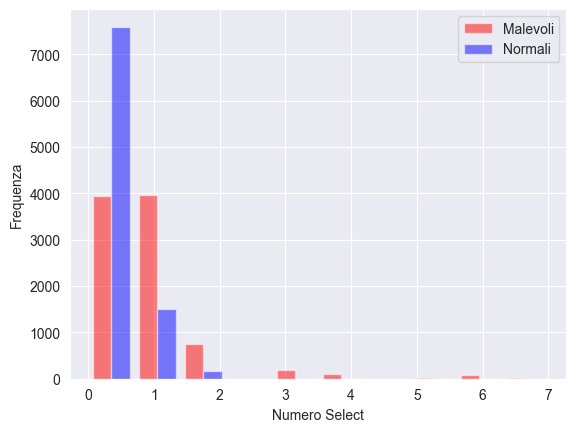

In [12]:

df_target_1 = df[df['Label'] == 1]
df_target_0 = df[df['Label'] == 0]

plt.hist([df_target_1['Select_Count'], df_target_0['Select_Count']], color=['r','b'], alpha=0.5)

plt.xlabel('Numero Select')
plt.ylabel('Frequenza')
plt.legend(['Malevoli', 'Normali'])

plt.show()


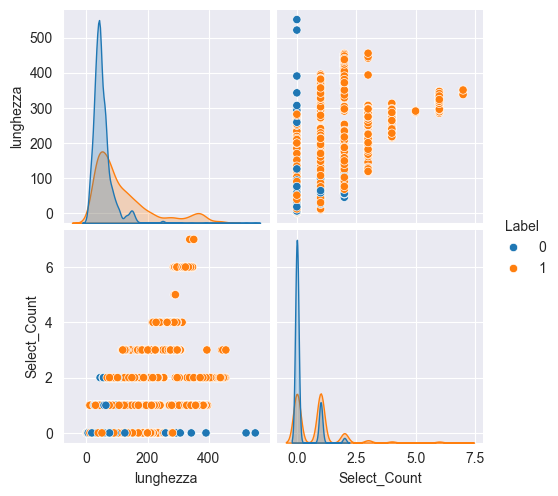

In [13]:
sns.pairplot(df, hue='Label')

Normalizzo i valori numerici

In [14]:
scaler = MinMaxScaler()
df[['lunghezza', 'Select_Count']] = scaler.fit_transform(df[['lunghezza', 'Select_Count']])
df

,Query,Label,lunghezza,Select_Count
26851,fairly ( s from volume right join,0,0.059783,0.000000
1866,1' in boolean mode ) order by 1--,1,0.065217,0.000000
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1,0.117754,0.000000
26246,* from tone where several between '1996-07-01'...,0,0.114130,0.000000
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1,0.300725,0.000000
...,...,...,...,...
19976,"left ( customername, 5 ) as extractstring fro...",0,0.105072,0.000000
29587,* from her where yes between deep09/01/1996sle...,0,0.137681,0.000000
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1,0.092391,0.000000
860,"* from users where id = 1 or 1#""{ union sele...",1,0.135870,0.142857


Essendo il train set già bilanciato non devo effettuare operazioni di bilanciamento quindi procedo a dividerlo tra feature e label per l'addestramento
# Addestramento
## Naive bayes

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from scipy.sparse import hstack
import pickle
X = df[['Query', 'lunghezza', 'Select_Count']]  # caratteristiche
y = df['Label']  # target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer = CountVectorizer()
vectorizer.fit(X_train['Query'])

X_train_vec = vectorizer.transform(X_train['Query'])
X_test_vec = vectorizer.transform(X_test['Query'])
X_train_vec = hstack([X_train_vec, X_train[['lunghezza', 'Select_Count']].values])
X_test_vec = hstack([X_test_vec, X_test[['lunghezza', 'Select_Count']].values])

with open('models/count_vectorizer.sav', 'wb') as file:
    pickle.dump(vectorizer, file)

gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
 
gnb.fit(X_train_vec.toarray(), y_train)
bnb.fit(X_train_vec.toarray(), y_train)
mnb.fit(X_train_vec.toarray(), y_train)


MultinomialNB()

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score




y_pred_gnb = gnb.predict(X_test_vec.toarray())
y_pred_bnb = bnb.predict(X_test_vec.toarray())
y_pred_mnb = mnb.predict(X_test_vec.toarray())


accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
accuracy_bnb = accuracy_score(y_test, y_pred_bnb)
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)





f1_gnb = f1_score(y_test, y_pred_gnb, average='weighted')
f1_bnb = f1_score(y_test, y_pred_bnb, average='weighted')
f1_mnb = f1_score(y_test, y_pred_mnb, average='weighted')
precision_gnb = precision_score(y_test, y_pred_gnb, average='weighted')
precision_bnb = precision_score(y_test, y_pred_bnb, average='weighted')
precision_mnb = precision_score(y_test, y_pred_mnb, average='weighted')
recall_gnb = recall_score(y_test, y_pred_gnb, average='weighted')
recall_bnb = recall_score(y_test, y_pred_bnb, average='weighted')
recall_mnb = recall_score(y_test, y_pred_mnb, average='weighted')
print(f"Accuratezza GaussianNB: {accuracy_gnb}")
print(f"Accuratezza BernoulliNB: {accuracy_bnb}")
print(f"Accuratezza MultinomialNB: {accuracy_mnb}")
print(f"F1 Score GaussianNB: {f1_gnb}")
print(f"F1 Score BernoulliNB: {f1_bnb}")
print(f"F1 Score MultinomialNB: {f1_mnb}")
print(f"Precision GaussianNB: {precision_gnb}")
print(f"Precision BernoulliNB: {precision_bnb}")
print(f"Precision MultinomialNB: {precision_mnb}")
print(f"Recall GaussianNB: {recall_gnb}")
print(f"Recall BernoulliNB: {recall_bnb}")
print(f"Recall MultinomialNB: {recall_mnb}")


Accuratezza GaussianNB: 0.8905866302864939
Accuratezza BernoulliNB: 0.9664392905866303
Accuratezza MultinomialNB: 0.9770804911323329
F1 Score GaussianNB: 0.8891424649473036
F1 Score BernoulliNB: 0.9663936047916323
F1 Score MultinomialNB: 0.977066209410842
Precision GaussianNB: 0.9098552914583584
Precision BernoulliNB: 0.9683283944231942
Precision MultinomialNB: 0.9778506249323123
Recall GaussianNB: 0.8905866302864939
Recall BernoulliNB: 0.9664392905866303
Recall MultinomialNB: 0.9770804911323329


## Vector machines

In [ ]:


svc = SVC(probability=True)
linear_svc = LinearSVC()
linear_svc = CalibratedClassifierCV(linear_svc) 

svc.fit(X_train_vec.toarray(), y_train)
linear_svc.fit(X_train_vec.toarray(), y_train)



y_pred_svc = svc.predict(X_test_vec.toarray())
y_pred_linear_svc = linear_svc.predict(X_test_vec.toarray())


In [83]:


accuracy_svc = accuracy_score(y_test, y_pred_svc)
accuracy_linear = accuracy_score(y_test, y_pred_linear_svc)
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')
f1_linear = f1_score(y_test, y_pred_linear_svc, average='weighted')
precision_svc = precision_score(y_test, y_pred_svc, average='weighted')
precision_linear = precision_score(y_test, y_pred_linear_svc, average='weighted')
recall_svc = recall_score(y_test, y_pred_svc, average='weighted')
recall_linear = recall_score(y_test, y_pred_linear_svc, average='weighted')
print(f"Accuratezza SVC: {accuracy_svc}")
print(f"Accuratezza Linear: {accuracy_linear}")

print(f"F1 Score SVC: {f1_svc}")
print(f"F1 Score Linear: {f1_linear}")

print(f"Precision SVC: {precision_svc}")
print(f"Precision Linear: {precision_linear}")

print(f"Recall SVC: {recall_svc}")
print(f"Recall Linear: {recall_linear}")


Accuratezza SVC: 0.990450204638472
Accuratezza Linear: 0.9923601637107776
F1 Score SVC: 0.9904503041732061
F1 Score Linear: 0.9923603559571965
Precision SVC: 0.9906310719748647
Precision Linear: 0.9924604339501713
Recall SVC: 0.990450204638472
Recall Linear: 0.9923601637107776


/Users/davideamoruso/SQLInjection_Detector/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


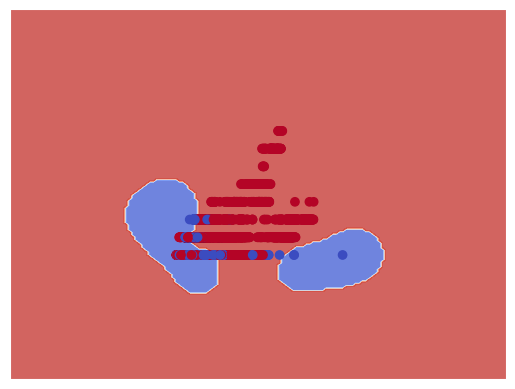

In [39]:

X_train_reduced = X_train[['lunghezza', 'Select_Count']]
X_test_reduced = X_test[['lunghezza', 'Select_Count']]
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC


svc = SVC()
svc.fit(X_train_reduced, y_train)


x_min, x_max = X_train_reduced['lunghezza'].min() - 1, X_train_reduced['lunghezza'].max() + 1
y_min, y_max = X_train_reduced['Select_Count'].min() - 1, X_train_reduced['Select_Count'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))


Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Disegna la mappa di decisione
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Disegna anche i punti di addestramento
plt.scatter(X_train_reduced['lunghezza'], X_train_reduced['Select_Count'], c=y_train, cmap=plt.cm.coolwarm)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.show()


/Users/davideamoruso/SQLInjection_Detector/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davideamoruso/SQLInjection_Detector/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


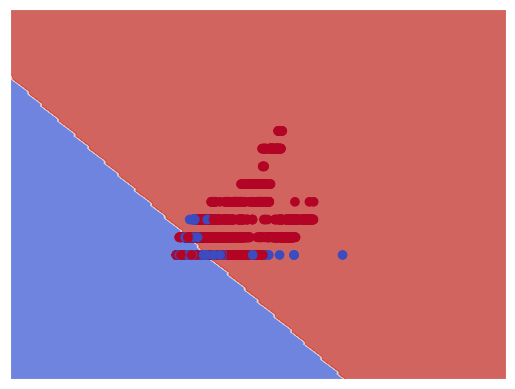

In [40]:


linear_svc = LinearSVC()
linear_svc.fit(X_train_reduced, y_train)


x_min, x_max = X_train_reduced['lunghezza'].min() - 1, X_train_reduced['lunghezza'].max() + 1
y_min, y_max = X_train_reduced['Select_Count'].min() - 1, X_train_reduced['Select_Count'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))


Z = linear_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)


plt.scatter(X_train_reduced['lunghezza'], X_train_reduced['Select_Count'], c=y_train, cmap=plt.cm.coolwarm)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.show()

## Nearest NeighBours

In [92]:



knc = KNeighborsClassifier()
rnc = RadiusNeighborsClassifier(radius=12.0)

 


knc.fit(X_train_vec.toarray(), y_train)
rnc.fit(X_train_vec.toarray(), y_train)



y_pred_knc = knc.predict(X_test_vec.toarray())
y_pred_rnc = rnc.predict(X_test_vec.toarray())



accuracy_knc = accuracy_score(y_test, y_pred_knc)
accuracy_rnc = accuracy_score(y_test, y_pred_rnc)





InvalidParameterError: The 'estimator' parameter of CalibratedClassifierCV must be an object implementing 'fit' and 'predict_proba', an object implementing 'fit' and 'decision_function' or None. Got NearestCentroid() instead.

In [41]:
f1_knc = f1_score(y_test, y_pred_knc, average='weighted')
f1_rnc = f1_score(y_test, y_pred_rnc, average='weighted')


precision_knc = precision_score(y_test, y_pred_knc, average='weighted')
precision_rnc = precision_score(y_test, y_pred_rnc, average='weighted')


recall_knc = recall_score(y_test, y_pred_knc, average='weighted')
recall_rnc = recall_score(y_test, y_pred_rnc, average='weighted')


print(f"Accuratezza KNeighborsClassifier: {accuracy_knc}")
print(f"Accuratezza RadiusNeighborsClassifier: {accuracy_rnc}")

print(f"F1 Score KNeighborsClassifier: {f1_knc}")
print(f"F1 Score RadiusNeighborsClassifier: {f1_rnc}")
print(f"F1 Score NearestCentroid: {f1_nc}")
print(f"Precision KNeighborsClassifier: {precision_knc}")
print(f"Precision RadiusNeighborsClassifier: {precision_rnc}")

print(f"Recall KNeighborsClassifier: {recall_knc}")
print(f"Recall RadiusNeighborsClassifier: {recall_rnc}")



Accuratezza KNeighborsClassifier: 0.940518417462483
Accuratezza RadiusNeighborsClassifier: 0.5421555252387449
Accuratezza NearestCentroid: 0.834924965893588
F1 Score KNeighborsClassifier: 0.9403657589941742
F1 Score RadiusNeighborsClassifier: 0.41633613295014854
F1 Score NearestCentroid: 0.830081623971186
Precision KNeighborsClassifier: 0.9462154430705103
Precision RadiusNeighborsClassifier: 0.7597937769807807
Precision NearestCentroid: 0.8746637316166548
Recall KNeighborsClassifier: 0.940518417462483
Recall RadiusNeighborsClassifier: 0.5421555252387449
Recall NearestCentroid: 0.834924965893588


## Decision Tree


In [74]:



dtc = DecisionTreeClassifier()
etc = ExtraTreeClassifier()


dtc.fit(X_train_vec.toarray(), y_train)
etc.fit(X_train_vec.toarray(), y_train)


y_pred_dtc = dtc.predict(X_test_vec.toarray())
y_pred_etc = etc.predict(X_test_vec.toarray())




In [43]:


accuracy_dtc = accuracy_score(y_test, y_pred_dtc)
accuracy_etc = accuracy_score(y_test, y_pred_etc)

f1_dtc = f1_score(y_test, y_pred_dtc, average='weighted')
f1_etc = f1_score(y_test, y_pred_etc, average='weighted')

precision_dtc = precision_score(y_test, y_pred_dtc, average='weighted')
precision_etc = precision_score(y_test, y_pred_etc, average='weighted')

recall_dtc = recall_score(y_test, y_pred_dtc, average='weighted')
recall_etc = recall_score(y_test, y_pred_etc, average='weighted')

print(f"Accuratezza DecisionTreeClassifier: {accuracy_dtc}")
print(f"Accuratezza ExtraTreeClassifier: {accuracy_etc}")
print(f"F1 Score DecisionTreeClassifier: {f1_dtc}")
print(f"F1 Score ExtraTreeClassifier: {f1_etc}")
print(f"Precision DecisionTreeClassifier: {precision_dtc}")
print(f"Precision ExtraTreeClassifier: {precision_etc}")
print(f"Recall DecisionTreeClassifier: {recall_dtc}")
print(f"Recall ExtraTreeClassifier: {recall_etc}")


Accuratezza DecisionTreeClassifier: 0.9923601637107776
Accuratezza ExtraTreeClassifier: 0.9888130968622101
F1 Score DecisionTreeClassifier: 0.9923603730260981
F1 Score ExtraTreeClassifier: 0.9888131584924373
Precision DecisionTreeClassifier: 0.9923984085434339
Precision ExtraTreeClassifier: 0.9890147963574729
Recall DecisionTreeClassifier: 0.9923601637107776
Recall ExtraTreeClassifier: 0.9888130968622101


## Random Forest

In [61]:



rfc = RandomForestClassifier()
etc = ExtraTreesClassifier()


rfc.fit(X_train_vec.toarray(), y_train)
etc.fit(X_train_vec.toarray(), y_train)


y_pred_rfc = rfc.predict(X_test_vec.toarray())
y_pred_etc = etc.predict(X_test_vec.toarray())


In [45]:
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
accuracy_etc = accuracy_score(y_test, y_pred_etc)
f1_rfc = f1_score(y_test, y_pred_rfc, average='weighted')
f1_etc = f1_score(y_test, y_pred_etc, average='weighted')

precision_rfc = precision_score(y_test, y_pred_rfc, average='weighted')
precision_etc = precision_score(y_test, y_pred_etc, average='weighted')

recall_rfc = recall_score(y_test, y_pred_rfc, average='weighted')
recall_etc = recall_score(y_test, y_pred_etc, average='weighted')

print(f"Accuratezza RandomForestClassifier: {accuracy_rfc}")
print(f"Accuratezza ExtraTreesClassifier: {accuracy_etc}")
print(f"F1 Score RandomForestClassifier: {f1_rfc}")
print(f"F1 Score ExtraTreesClassifier: {f1_etc}")
print(f"Precision RandomForestClassifier: {precision_rfc}")
print(f"Precision ExtraTreesClassifier: {precision_etc}")
print(f"Recall RandomForestClassifier: {recall_rfc}")
print(f"Recall ExtraTreesClassifier: {recall_etc}")


Accuratezza RandomForestClassifier: 0.9918144611186903
Accuratezza ExtraTreesClassifier: 0.992087312414734
F1 Score RandomForestClassifier: 0.9918146488142275
F1 Score ExtraTreesClassifier: 0.9920875032794837
Precision RandomForestClassifier: 0.9919306176702839
Precision ExtraTreesClassifier: 0.9921953820040026
Recall RandomForestClassifier: 0.9918144611186903
Recall ExtraTreesClassifier: 0.992087312414734


# Utility

## labels of the query for deployment testing

In [ ]:
y_use

## Query for deployment testing

In [ ]:
x_use

## Model exporter

In [ ]:
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)


## Confusion matrix generator

In [ ]:

conf_matrix = confusion_matrix(y_test, y_pred_gnb)
sns.heatmap(conf_matrix, annot=True, fmt="d",cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')

plt.show()

## Roc Curve

In [ ]:


fpr, tpr, _ = roc_curve(y_test, gnb.predict_proba(X_test_vec.toarray())[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()